<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Бустинг-(Light-GBM)" data-toc-modified-id="Бустинг-(Light-GBM)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Бустинг (Light GBM)</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование заказов такси

## Обзор данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
pd.set_option('display.float_format', '{:,.3f}'.format) #настройка, чтобы числа показывались с 3мя знаками после запятой и разделителем разрядов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from numpy.random import RandomState
from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [56]:
#читаем файлы, выводим информацию о датасете
#try - адрес у меня, except - адрес для проверки
try:
    data = pd.read_csv('datasets/taxi.csv')
except FileNotFoundError:
    print("file doesn't exist")

In [3]:
# выводим общую информацию о данных
display(data.head(10))
print()
display(data.info())
print()
print('Доли пропусков')
display(data.isna().mean())
print()
print('Проверка наличия дублирующихся строк')
data.duplicated().sum()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None


Доли пропусков


datetime     0.000
num_orders   0.000
dtype: float64


Проверка наличия дублирующихся строк


0

**Выводы по данным:**  
1. В датафрейме 26496 строк, 2 столбца: "datetime" с датой и временем (по всей видимости с шагом 10 минут) и "num_orders" с количеством заказов за указанный период.  
2. Пропуски и дублирующиеся строки отсутствуют.  
3. Столбец "datetime" имеет формат object, хотя в нём содердатся даты и время. Необходимо перевести в datetime.

In [57]:
## изменим тип данных в столбце datetime
data['datetime'] = pd.to_datetime(data['datetime'],format = '%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


## Анализ данных

In [5]:
# проверим, расположены ли данные в хронологическом порядке
data['datetime'].is_monotonic

True

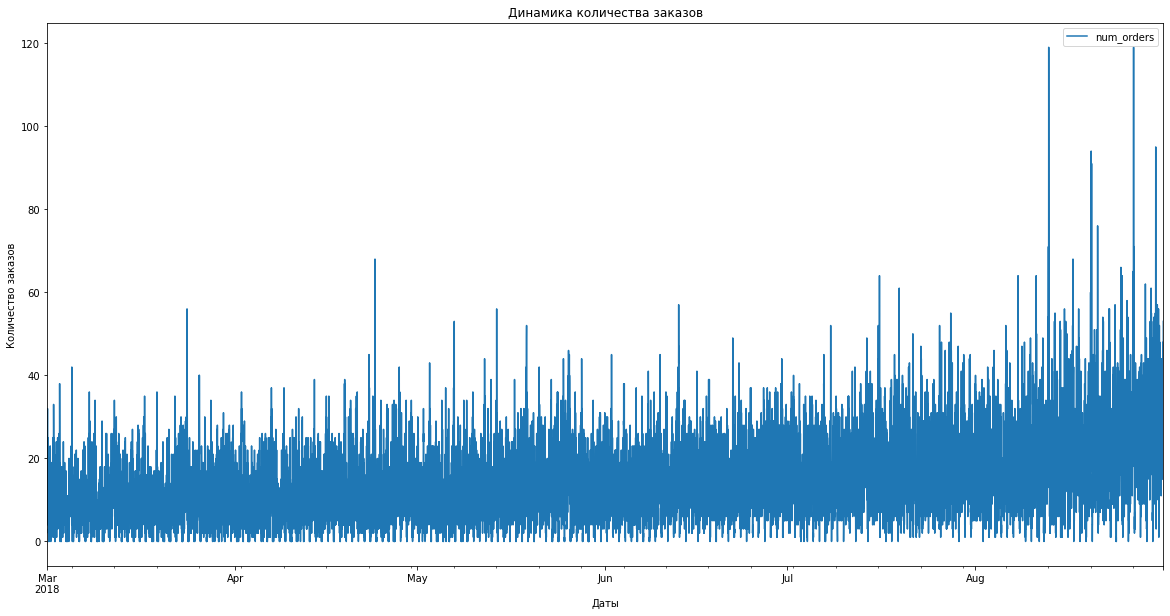

In [6]:
data.plot(x='datetime', y='num_orders', figsize=(20,10), title='Динамика количества заказов')
plt.xlabel('Даты')
plt.ylabel('Количество заказов');

In [58]:
# выведем общую статистическую информацию
display(data.describe(datetime_is_numeric=True))

,datetime,num_orders
count,26496,"26,496.000"
mean,2018-05-31 23:55:00,14.070
min,2018-03-01 00:00:00,0.000
25%,2018-04-15 23:57:30,8.000
50%,2018-05-31 23:55:00,13.000
75%,2018-07-16 23:52:30,19.000
max,2018-08-31 23:50:00,119.000
std,NaN,9.211


В датасете представлены данные с 01.03.2018 по 31.08.2018, т.е. за 6 месяцев. Каждый квартиль заниvает по 1,5 месяца, т.е. даты распределяются логично.  
Минимальное количество заказов 0, что возможно, но необходимо оценить количество таких позиций и время, в которое они возникали (например, поздней ночью может не быть заказов).   
Максимальное количество заказов - 462, что странно, учитывая, что на 3 квартиле их всего 107. Нужно оценить число записей с таким большим количеством заказов. В рабочей задаче это необходимо было бы уточнить, какое количество заказов является максимально возможным за час.

Оценим сезонную составляющую и тренд в данных.  
Данные представлены с интервалом в 10 минут. Для анализа их необходимо сгруппировать до часа.

In [59]:
# делаем ресмеплинг данных до 1 часа
data = data.set_index('datetime')
data = data.resample('1H').sum()
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


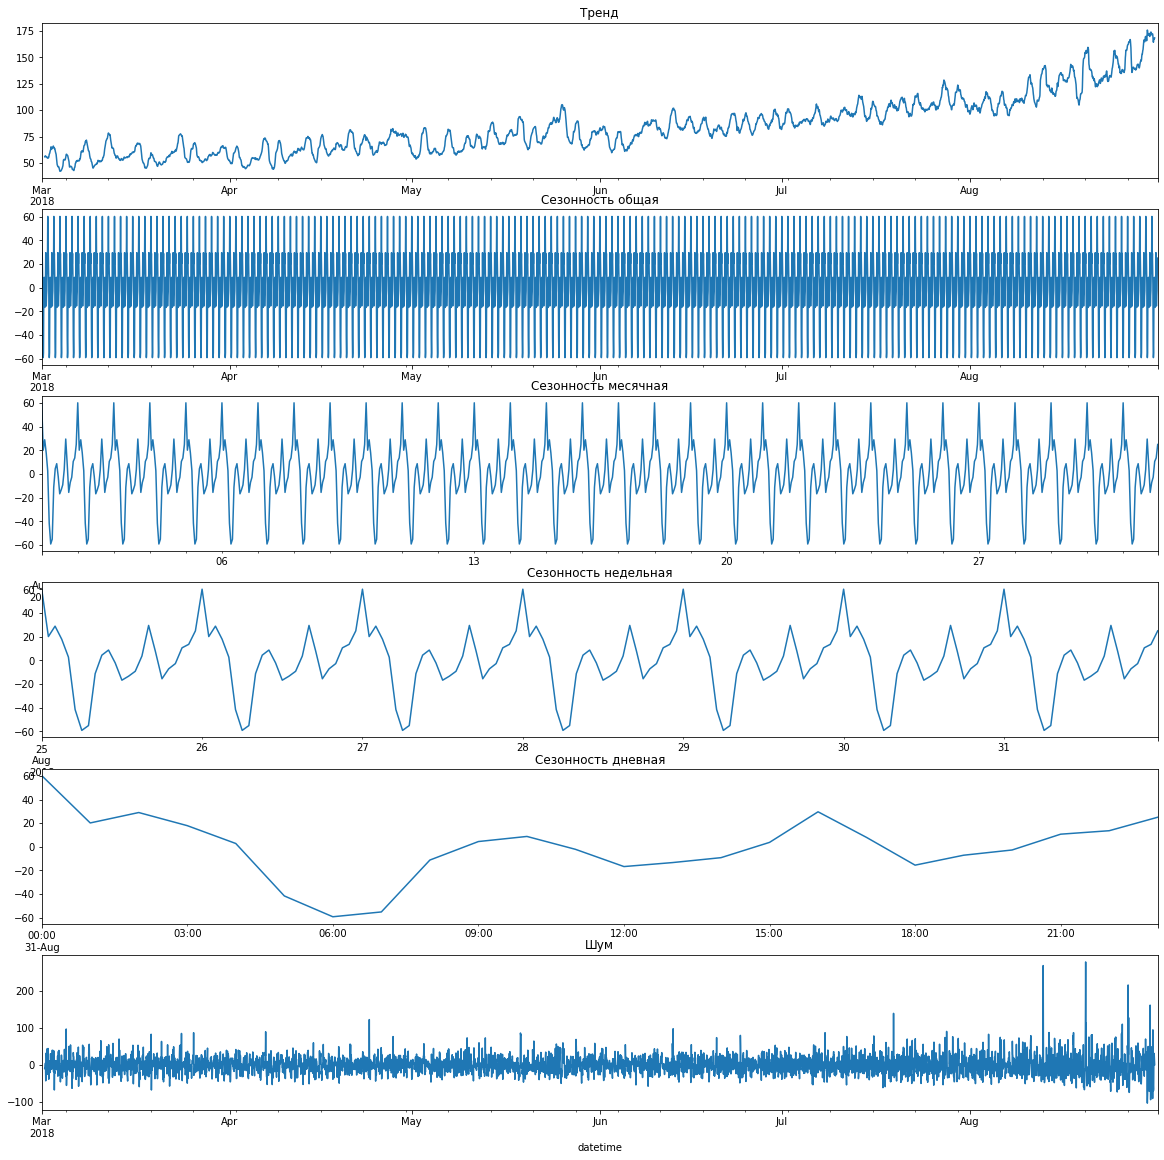

In [60]:
decomposed_data = seasonal_decompose(data)
plt.figure(figsize=(20,20))
plt.subplot(611)
decomposed_data.trend.plot(title='Тренд', ax=plt.gca())
plt.subplot(612)
decomposed_data.seasonal.plot(title='Сезонность общая', ax=plt.gca())
plt.subplot(613)
decomposed_data.seasonal['2018-08'].plot(title='Сезонность месячная', ax=plt.gca()) #по последнему месяцу
plt.subplot(614)
decomposed_data.seasonal['2018-08-25':'2018-08-31'].plot(title='Сезонность недельная', ax=plt.gca()) #по последнему месяцу
plt.subplot(615)
decomposed_data.seasonal['2018-08-31'].plot(title='Сезонность дневная', ax=plt.gca()) #по последнему дню
plt.subplot(616)
decomposed_data.resid.plot(title='Шум', ax=plt.gca());


По итогу видим явный тренд к повышению количества заказов за исследуемый период, усиливающийся начианя с июня.  
В данных наблюдается суточная сезонность. Годовую оценить невозможно, т.к. данные только за полгода.  
Для анализа данных нужно добавить в датасет столбцы с месяцами, часами и днями недели заказов, т.к. от этих параметров скорее всего будет зависеть количество заказов.

In [10]:
data['hour'] = data.index.hour
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
display(data.head(10))

,num_orders,hour,month,dayofweek
datetime,,,,
2018-03-01 00:00:00,124,0,3,3
2018-03-01 01:00:00,85,1,3,3
2018-03-01 02:00:00,71,2,3,3
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,4,3,3
2018-03-01 05:00:00,6,5,3,3
2018-03-01 06:00:00,12,6,3,3
2018-03-01 07:00:00,15,7,3,3
2018-03-01 08:00:00,34,8,3,3


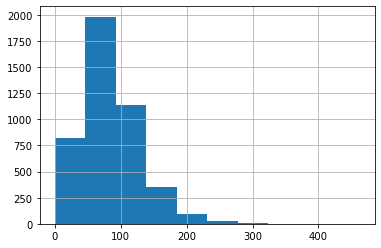

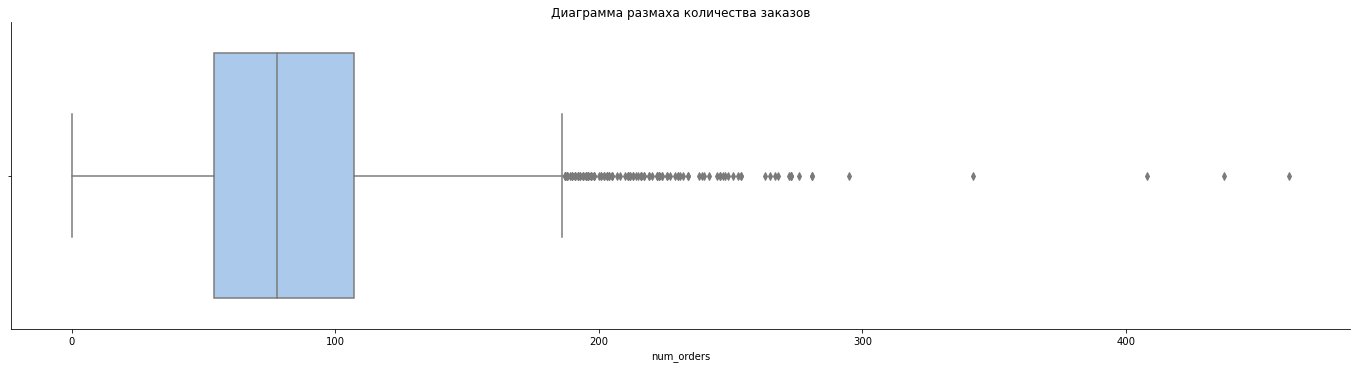

In [12]:
# оценим распределение количества заказов
data['num_orders'].hist()
g = sns.catplot(x='num_orders', kind="box", data=data, orient='h', palette = 'pastel')
g.fig.set_figwidth(20)
g.fig.set_figheight(5)
plt.title('Диаграмма размаха количества заказов');

Количество записей с нулевыми заказами 1
Доля записей с нулевыми заказами 0.00022644927536231884


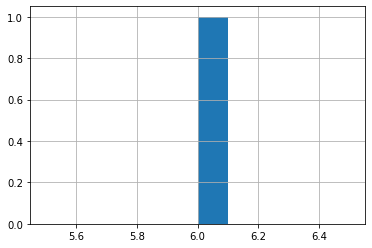

In [13]:
# выведем информацию о нулевых заказах
print('Количество записей с нулевыми заказами',data[data['num_orders']==0]['num_orders'].count())
print('Доля записей с нулевыми заказами',data[data['num_orders']==0]['num_orders'].count()/data.shape[0])

data[data['num_orders']==0]['hour'].hist();

Действительно видим, что основная часть записей с нулевым количеством заказов приходится на ночь и раннее утро, т.е. вряд ли это аномалия. Но в рабочей задаче всё равно нужно было бы проверить корректность данных.

Верхняя граница 219.4943410551636
Количество выбросов в количестве заказов 49
Доля выбросов в общем количестве заказов 0.011096014492753624


<AxesSubplot:>

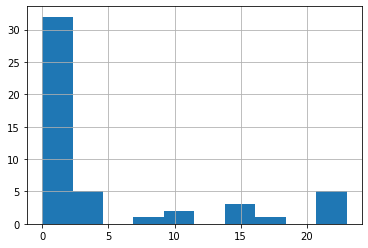

In [14]:
# выведем информацию о выбросах: количестве заказов, превышающем 3 среднеквадратических отклонения от среднего
outliers_high = data['num_orders'].mean()+3*data['num_orders'].std() 
print('Верхняя граница', outliers_high)
data_big = data[data['num_orders']>=outliers_high]
print('Количество выбросов в количестве заказов',data_big.shape[0])
print('Доля выбросов в общем количестве заказов',data_big.shape[0]/data.shape[0])

data_big['hour'].hist()

Видим, что заказы бывают в разное время, но странно, что большая часть записей с выбросами расположена в диапазоне с полуночи до 5 утра. 

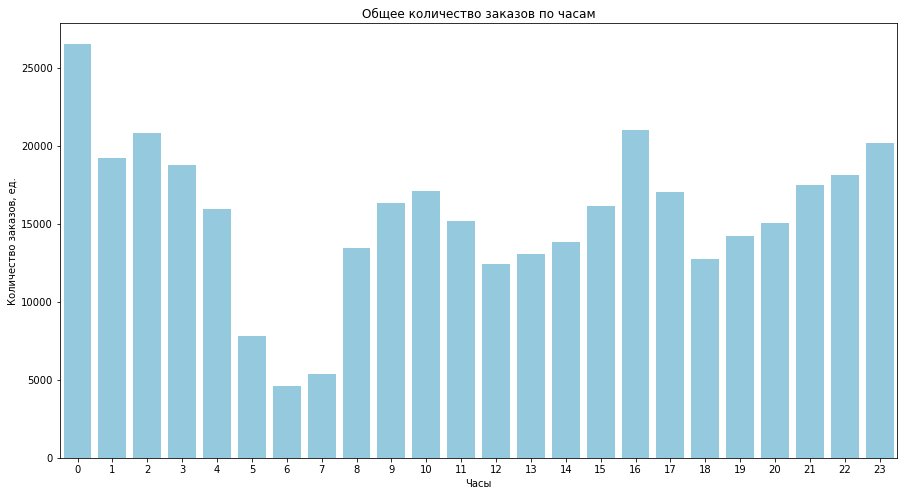

In [15]:
#Выведем общее количество заказов по часам
plt.figure(figsize=(15,8))
sns.barplot(
    x="hour", 
    y="num_orders", 
    data=data, 
    estimator=sum, 
    ci=None, 
    color='skyblue').set_title('Общее количество заказов по часам')
plt.xlabel('Часы')
plt.ylabel('Количество заказов, ед.');

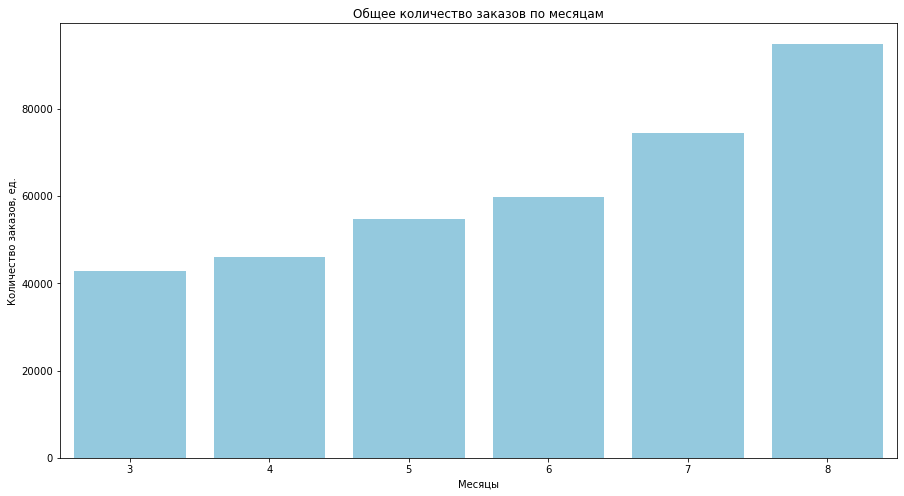

In [16]:
#Выведем общее количество заказов по месяцам
plt.figure(figsize=(15,8))
sns.barplot(
    x="month", 
    y="num_orders", 
    data=data, 
    estimator=sum, 
    ci=None, 
    color='skyblue').set_title('Общее количество заказов по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов, ед.');

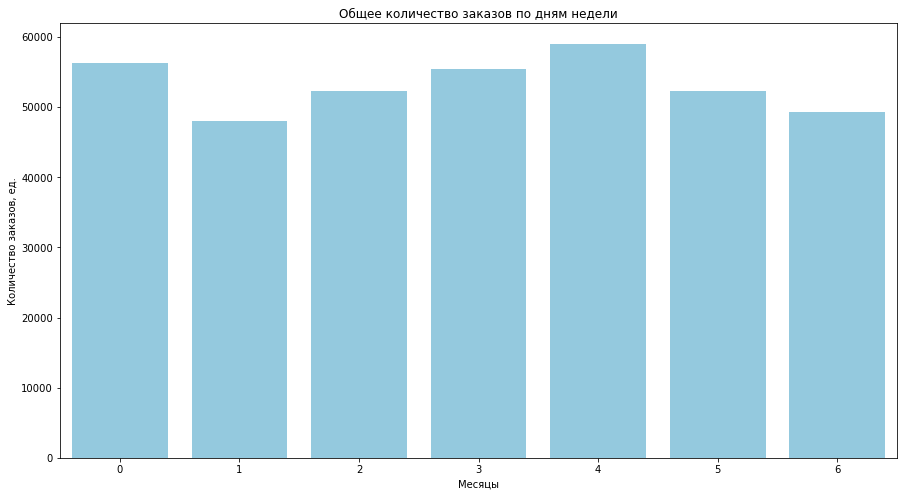

In [17]:
#Выведем общее количество заказов по дням недели
plt.figure(figsize=(15,8))
sns.barplot(
    x="dayofweek", 
    y="num_orders", 
    data=data, 
    estimator=sum, 
    ci=None, 
    color='skyblue').set_title('Общее количество заказов по дням недели')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов, ед.');

Действительно наименьшее количество заказов фиксируется в промежутке 5-7 часов утра.  
Поскольку данных о нормальном количестве заказов для компании у нас нет, сложно определить границу, выше которой количество заказов следует считать аномалией. Заполним значения, которые больше 3х среднеквадратических отклонений от среднего значением предыдущего интервала.

In [18]:
data['num_orders'] = np.where(data['num_orders']>outliers_high,np.nan,data['num_orders'])
data['num_orders'] = data['num_orders'].ffill()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
 1   hour        4416 non-null   int64  
 2   month       4416 non-null   int64  
 3   dayofweek   4416 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 172.5 KB


In [20]:
print('Количество выбросов в количестве заказов',data[data['num_orders']>=outliers_high].shape[0])
print('Доля выбросов в общем количестве заказов',data[data['num_orders']>=outliers_high].shape[0]/data.shape[0])

Количество выбросов в количестве заказов 0
Доля выбросов в общем количестве заказов 0.0


## Подготовка данных

In [21]:
# создаем класс для добавления столбцов и разделения выборок на обучающую и тестовую
class FeaturesMaker:
    def __init__(self, target_name, max_lag, rolling_size):
        self.target_name = target_name
        self.max_lag = max_lag
        self.rolling_size = rolling_size
        
    def fit(self,data):
        data = data
        
    def transform(self,data):
        for lag in range(1,self.max_lag+1):
            data['lag_{}'.format(lag)] = data[self.target_name].shift(lag)
        data['rolling_mean'] = data[self.target_name].shift().rolling(self.rolling_size).mean()
        data = data.dropna()
        
        features=data.drop(self.target_name,axis=1)
        target = data[self.target_name]
        features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.1,shuffle=False)
        return features_train,features_test,target_train,target_test



In [22]:
features_maker = FeaturesMaker('num_orders',20,10)
features_train,features_test,target_train,target_test = features_maker.transform(data)

In [23]:
print(features_train.shape,target_train.shape)
print(features_test.shape,target_test.shape)
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

(3956, 24) (3956,)
(440, 24) (440,)
2018-03-01 20:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [24]:
features_train.head()

,hour,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,20,3,3,45.000,73.000,44.000,43.000,66.000,48.000,32.000,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,71.000,85.000,124.000,54.100
2018-03-01 21:00:00,21,3,3,61.000,45.000,73.000,44.000,43.000,66.000,48.000,32.000,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,71.000,85.000,53.800
2018-03-01 22:00:00,22,3,3,66.000,61.000,45.000,73.000,44.000,43.000,66.000,48.000,32.000,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,71.000,50.800
2018-03-01 23:00:00,23,3,3,113.000,66.000,61.000,45.000,73.000,44.000,43.000,66.000,48.000,32.000,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,66.000,59.100
2018-03-02 00:00:00,0,3,4,58.000,113.000,66.000,61.000,45.000,73.000,44.000,43.000,66.000,48.000,32.000,30.000,96.000,64.000,69.000,34.000,15.000,12.000,6.000,43.000,61.700


## Обучение моделей

### Константная модель

In [25]:
# rmse для константной модели: среднее значение
predictions_const = pd.Series(target_train.mean(),index=target_train.index)
rmse_const_train = mean_squared_error(target_train,predictions_const,squared=False)
print('RMSE константной модели на обучающей выборке: {:.2f}'.format(rmse_const_train))

result = []
params = []
result.append(rmse_const_train)
params.append('')

RMSE константной модели на обучающей выборке: 37.27


### Дерево решений

In [26]:
%%time
# подбираем параметры модели
cv = TimeSeriesSplit(n_splits=5)
model = DecisionTreeRegressor(random_state=12345)
parametrs_dt = {'max_depth':range(1,20),
                'min_samples_split':range(10,200,5), 
                'min_samples_leaf':range(1,50,1)}
df_dt_params = RandomizedSearchCV(model,parametrs_dt,n_jobs=4, cv=cv, scoring='neg_root_mean_squared_error')
df_dt_params.fit(features_train, target_train)
print('Лучшие гиперпараметры:',df_dt_params.best_params_)
print('Лучший RMSE:',-df_dt_params.best_score_)
result.append(-df_dt_params.best_score_)
params.append(df_dt_params.best_params_)

if -df_dt_params.best_score_ < rmse_const_train:
    print('Показатель лучше константного.')
else:
    print('Показатель хуже константного.')

Лучшие гиперпараметры: {'min_samples_split': 50, 'min_samples_leaf': 36, 'max_depth': 9}
Лучший RMSE: 27.64812114522722
Показатель лучше константного.
Wall time: 2.46 s


### Линейная регрессия

In [27]:
%%time
# подбираем параметры модели
cv = TimeSeriesSplit(n_splits=5)
model = LinearRegression(n_jobs=4)
parametrs_lr = {'fit_intercept':[True,False],
            'normalize':[True,False],
            'copy_X':[True,False]}
lr_params = GridSearchCV(model,parametrs_lr,n_jobs=4, cv=cv, scoring='neg_root_mean_squared_error')
lr_params.fit(features_train, target_train)
print('Лучшие гиперпараметры:', lr_params.best_params_)
print('Лучший RMSE:',-lr_params.best_score_)
result.append(-lr_params.best_score_)
params.append(lr_params.best_params_)


if -lr_params.best_score_ < rmse_const_train:
    print('Показатель лучше константного.')
else:
    print('Показатель хуже константного.')

Лучшие гиперпараметры: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Лучший RMSE: 29.93790947864209
Показатель лучше константного.
Wall time: 207 ms


### Случайный лес

In [28]:
%%time
# подбираем параметры модели
cv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(random_state=12345)
parametrs_rf = {'n_estimators':range(50, 100, 5),
                        'max_depth':range(5, 21)} 
df_rf_params = RandomizedSearchCV(model,parametrs_rf,n_jobs=4, cv=cv, scoring='neg_root_mean_squared_error')
df_rf_params.fit(features_train, target_train)
print('Лучшие гиперпараметры:',df_rf_params.best_params_)
print('Лучший RMSE:', -df_rf_params.best_score_)
result.append(-df_rf_params.best_score_)
params.append(df_rf_params.best_params_)


if -df_rf_params.best_score_ < rmse_const_train:
    print('Показатель лучше константного.')
else:
    print('Показатель хуже константного.')


Лучшие гиперпараметры: {'n_estimators': 90, 'max_depth': 14}
Лучший RMSE: 24.174573003220257
Показатель лучше константного.
Wall time: 31.1 s


### Бустинг (Light GBM)

In [29]:
%%time
cv = TimeSeriesSplit(n_splits=5)
model_boost = lgb.LGBMRegressor()
parametrs_bst = {'objective':['regression_l2','regression_l1','regression'],
            'n_estimators':[10,100,500,1000,1500,2000],
            'max_depth':range(1,10,1),
        
            'learning_rate':[0.01,0.1,0.15,0.2,0.25,0.3]}
bst_parametrs = GridSearchCV(model_boost,parametrs_bst,n_jobs=4, cv=cv, scoring='neg_root_mean_squared_error')
bst_parametrs.fit(features_train, target_train)
print('Лучшие гиперпараметры:', bst_parametrs.best_params_)
print('Лучший RMSE:',-bst_parametrs.best_score_)
result.append(-bst_parametrs.best_score_)
params.append(bst_parametrs.best_params_)



if -bst_parametrs.best_score_ < rmse_const_train:
    print('Показатель лучше константного.')
else:
    print('Показатель хуже константного.')

Лучшие гиперпараметры: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'objective': 'regression_l2'}
Лучший RMSE: 23.814827899183634
Показатель лучше константного.
Wall time: 12min 25s


### Анализ результатов

In [30]:
results = pd.DataFrame({'model':['Constant','Decision Tree', 'Linear Regression', 'Random Forest', 'Boosting'],
                    'RMSE train' : result,
                       'Parametrs' :params})

display(results)

,model,RMSE train,Parametrs
0,Constant,37.275,
1,Decision Tree,27.648,"{'min_samples_split': 50, 'min_samples_leaf': ..."
2,Linear Regression,29.938,"{'copy_X': True, 'fit_intercept': False, 'norm..."
3,Random Forest,24.175,"{'n_estimators': 90, 'max_depth': 14}"
4,Boosting,23.815,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est..."


результаты всех моделей превосходят константную модель и целевое значение RMSE (48).  
Лучший результат у LGBMRegressor, RandomForestRegressor отстает несущественно.  
Протестируем модель на основе LGBM.

## Тестирование моделей

In [33]:
%%time
# Обучим модель на лучших параметрах
model_boost = lgb.LGBMRegressor(objective=bst_parametrs.best_params_['objective'], 
                                n_estimators=bst_parametrs.best_params_['n_estimators'],
                                max_depth=bst_parametrs.best_params_['max_depth'],
                                learning_rate=bst_parametrs.best_params_['learning_rate'])
model_boost.fit(features_train,target_train)
test_preds = model_boost.predict(features_test)
rmse_boosting_test = mean_squared_error(target_test,test_preds, squared=False)
print('RMSE test: {:.2f}'.format(rmse_boosting_test))

RMSE test: 33.91
Wall time: 505 ms


Text(0, 0.5, 'Количество заказов')

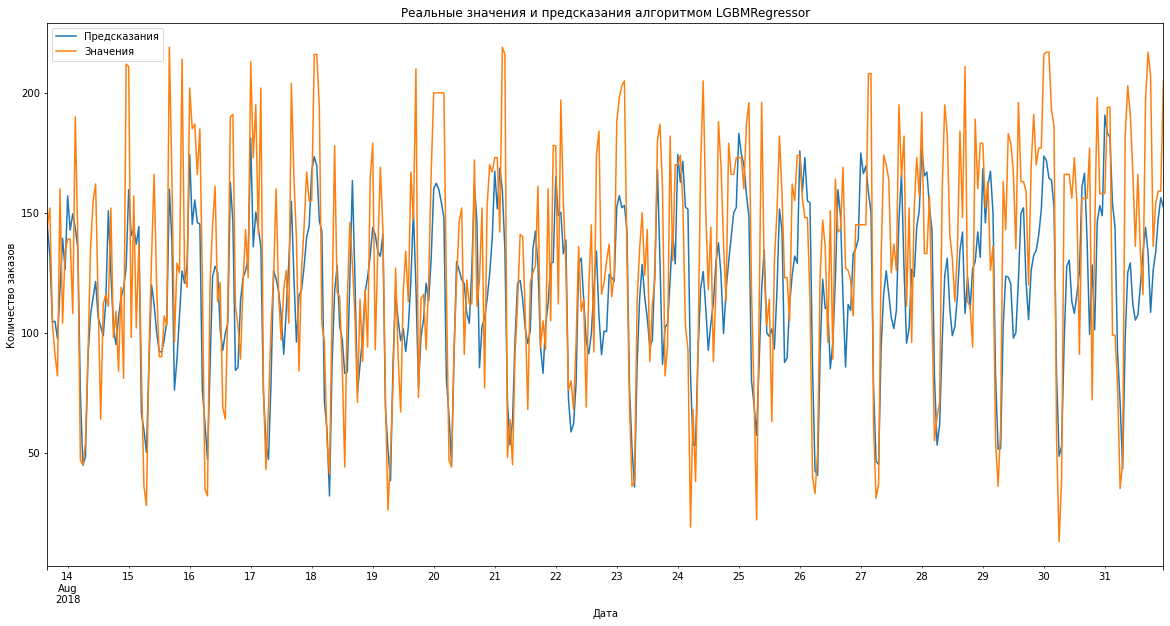

In [50]:
plt.figure(figsize=(20,10))
pd.Series(test_preds, index=target_test.index).plot()
target_test.plot()
plt.legend(['Предсказания', 'Значения'])
plt.title('Реальные значения и предсказания алгоритмом LGBMRegressor')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

## Общий вывод

В ходе исследования было сделано следующее: 
1. Исходные данные подготовлены для обучения (созданы признаки).
2. На базе полученных выборок обучены модели ('DecisionTreeRegressor', 'LinearRegression', 'RandomForestRegressor', 'LGBMRegressor')
3. Лучшей по итогам обучения оказалась модель LGBMRegressor с гиперпараметрами: 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'objective': 'regression_l2' . Лучший RMSE на обучающей выборке 23.815, лучший RMSE на тестовой выборке 33,91. Полученный результат по RMSE лучше заданного в условиях (48). Кроме того, данная модель быстрее работает.